In [7]:
from src.data_utils import *
from src.plot_utils import plot_standardized_comparison
import geopandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Exploratory Data Analysis

Visualize relationships between atmospheric variables and sea ice extent to identify potential predictive features.

In [3]:
data = load_data(regions='Central', years=range(2000, 2006))

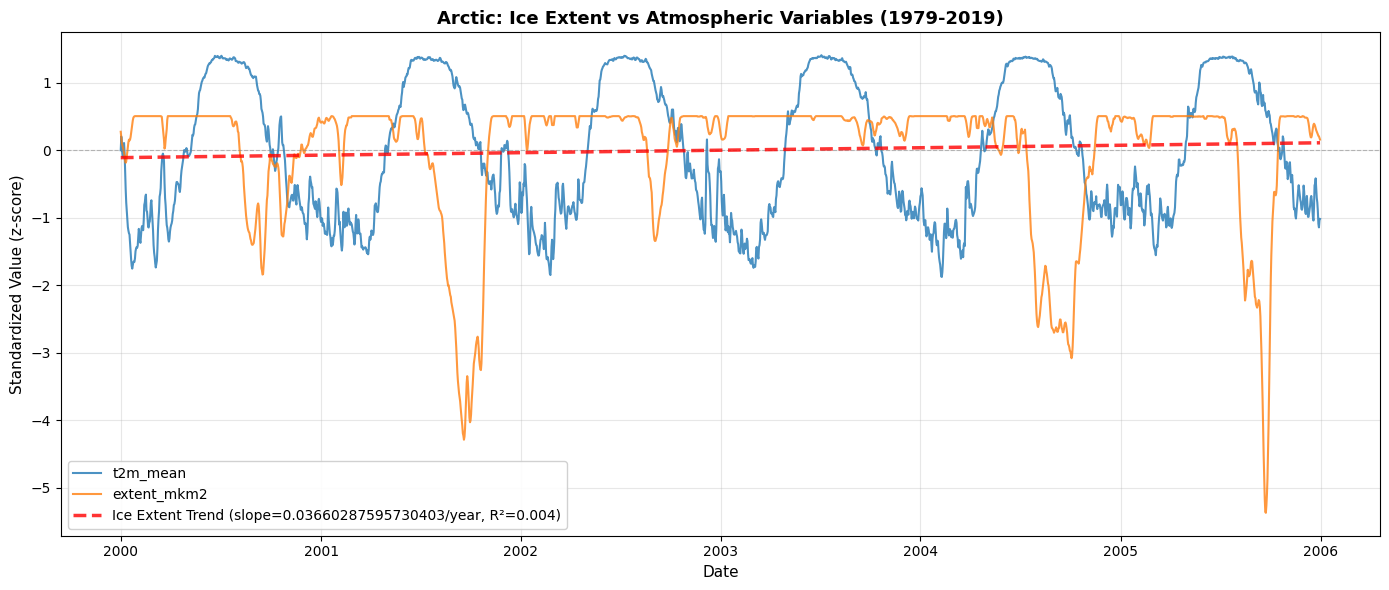

In [4]:
fig, ax = plot_standardized_comparison(
    data,
    columns=['t2m_mean', 'extent_mkm2'],
    title='Arctic: Ice Extent vs Atmospheric Variables (1979-2019)'
)

from scipy import stats

x = np.arange(len(data))
extent_standardized = (data['t2m_mean'] - data['t2m_mean'].mean()) / data['t2m_mean'].std()

slope, intercept, r_value, p_value, std_err = stats.linregress(x, extent_standardized)
trend_line = slope * x + intercept

ax.plot(data['date'], trend_line, 'r--', linewidth=2.5, alpha=0.8,
        label=f'Ice Extent Trend (slope={slope* 365 }/year, R²={r_value**2:.3f})')

ax.legend(loc='best', fontsize=10, framealpha=0.9)

plt.show()

In [5]:
data_bering = load_data(regions='Bering', years=range(2000, 2006))
data_east = load_data(regions='East', years=range(2000, 2006))
full_data = pd.concat([data_bering, data_east, data])

## Plot 1: Seasonal Cycle Heatmap

Visualize how ice extent varies by month across different regions to understand seasonal patterns and regional differences.

## Plot 3: Seasonal Cycle Heatmap

Visualize how ice extent varies by month across different regions to understand seasonal patterns and regional differences.

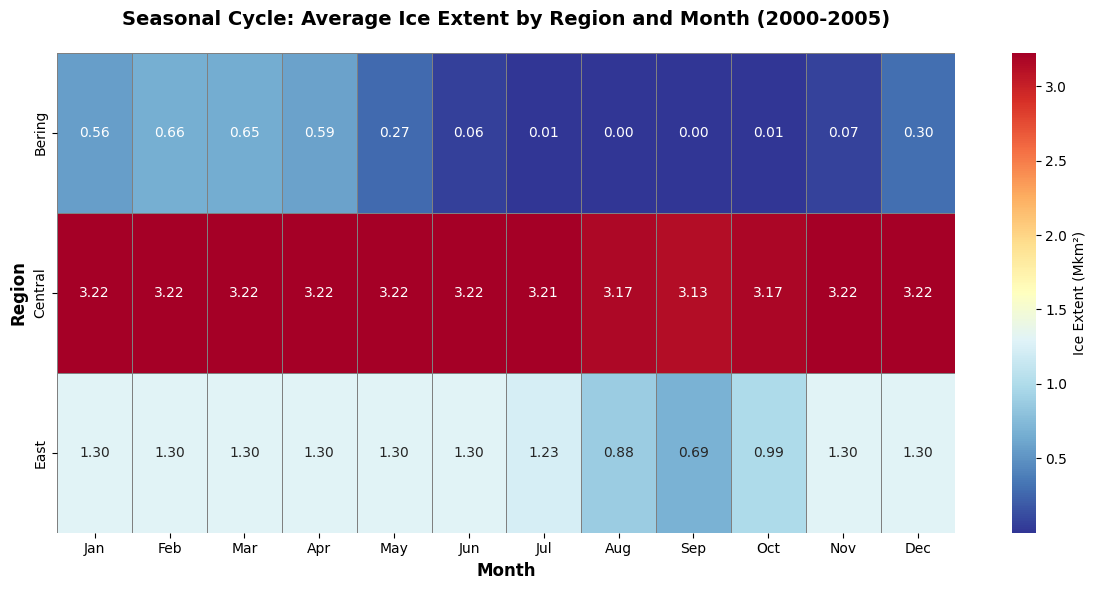

In [8]:
# Create seasonal cycle heatmap
# Extract month from date for seasonal analysis
full_data['month'] = full_data['date'].dt.month
full_data['month_name'] = full_data['date'].dt.strftime('%b')

# Calculate average ice extent by region and month
seasonal_pivot = full_data.groupby(['region', 'month', 'month_name'])['extent_mkm2'].mean().reset_index()
seasonal_matrix = seasonal_pivot.pivot(index='region', columns='month', values='extent_mkm2')

# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(
    seasonal_matrix, 
    annot=True, 
    fmt='.2f', 
    cmap='RdYlBu_r',  # Red (low ice) to Blue (high ice)
    cbar_kws={'label': 'Ice Extent (Mkm²)'},
    linewidths=0.5,
    linecolor='gray',
    ax=ax
)

# Customize appearance
ax.set_title('Seasonal Cycle: Average Ice Extent by Region and Month (2000-2005)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Month', fontsize=12, fontweight='bold')
ax.set_ylabel('Region', fontsize=12, fontweight='bold')

# Set month labels to abbreviated names
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticklabels(month_labels, rotation=0)

plt.tight_layout()
plt.show()

## Plot 4: Temperature vs Ice Extent (Colored by Season)

Explore the relationship between atmospheric temperature and ice extent, with seasonal coloring to reveal how this relationship varies throughout the year.

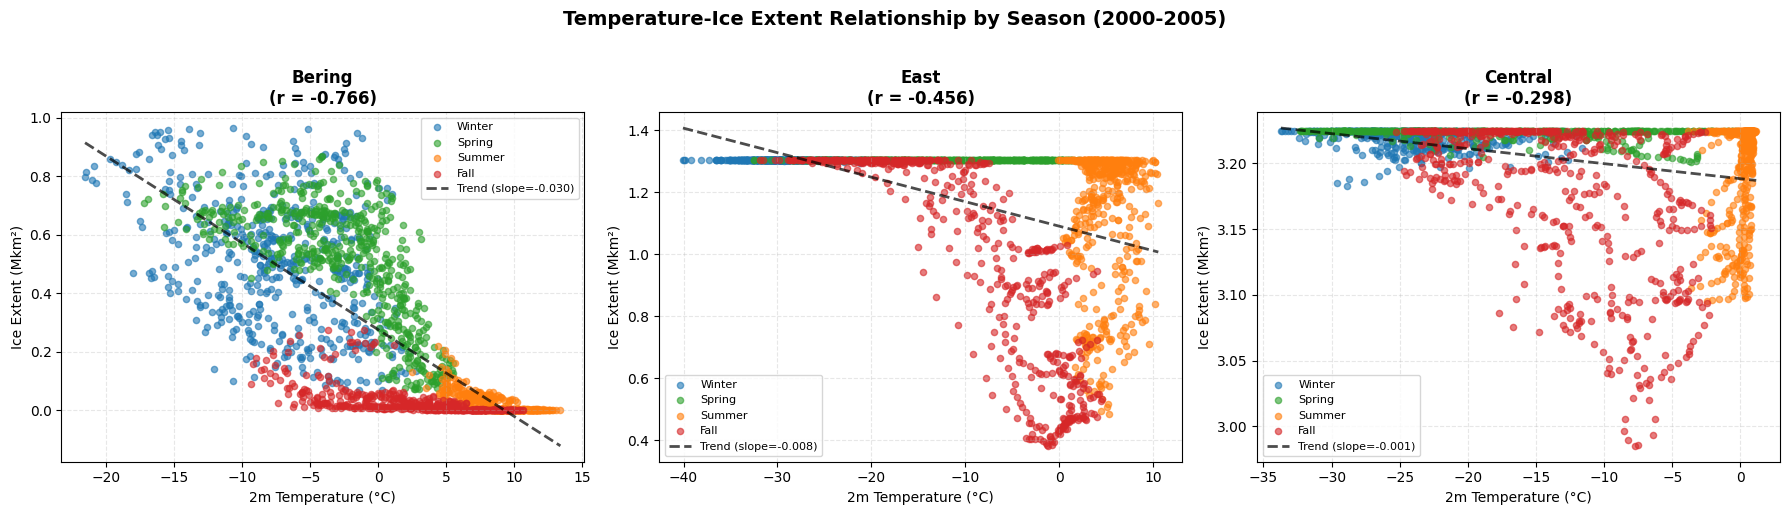

In [9]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

full_data['season'] = full_data['month'].apply(get_season)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

regions = full_data['region'].unique()
season_colors = {'Winter': '#1f77b4', 'Spring': '#2ca02c', 
                 'Summer': '#ff7f0e', 'Fall': '#d62728'}

for idx, region in enumerate(regions):
    ax = axes[idx]
    region_data = full_data[full_data['region'] == region]
    
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        season_data = region_data[region_data['season'] == season]
        ax.scatter(season_data['t2m_mean'], season_data['extent_mkm2'], 
                  c=season_colors[season], label=season, alpha=0.6, s=20)
    
    z = np.polyfit(region_data['t2m_mean'], region_data['extent_mkm2'], 1)
    p = np.poly1d(z)
    temp_range = np.linspace(region_data['t2m_mean'].min(), 
                             region_data['t2m_mean'].max(), 100)
    ax.plot(temp_range, p(temp_range), 'k--', linewidth=2, alpha=0.7,
           label=f'Trend (slope={z[0]:.3f})')
    
    corr = region_data[['t2m_mean', 'extent_mkm2']].corr().iloc[0, 1]
    
    ax.set_title(f'{region}\n(r = {corr:.3f})', fontsize=12, fontweight='bold')
    ax.set_xlabel('2m Temperature (°C)', fontsize=10)
    ax.set_ylabel('Ice Extent (Mkm²)', fontsize=10)
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='best', fontsize=8)

fig.suptitle('Temperature-Ice Extent Relationship by Season (2000-2005)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()